In [1]:
from fastai.vision.all import *

In [2]:
def get_data_loader(image_path, mask_path):
    # 使用fastai的DataBlock API
    dblock = DataBlock(
        blocks=(ImageBlock, MaskBlock(
            codes=['background', 'class1', 'class2', 'class3'])),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=lambda x: mask_path / f'{x.stem}.png',
        item_tfms=Resize(256),
        batch_tfms=aug_transforms(size=256)
    )
    return dblock.dataloaders(image_path, bs=16)


# 定义数据路径
image_path = Path('./data/images/training')
mask_path = Path('./data/annotations/training')

# 创建数据集
# 创建数据加载器
dls = get_data_loader(image_path, mask_path)

In [9]:
# 定义模型
learn = unet_learner(dls, resnet34, metrics=[Dice(), JaccardCoeffMulti()])
# 输出模型参数量
total_params = sum(p.numel() for p in learn.model.parameters() if p.requires_grad)
print(f"模型参数量: {total_params / 1e6:.2f}M")


模型参数量: 19.95M


In [8]:
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 调试代码
xb, yb = dls.one_batch()
xb = xb.to(device)
yb = yb.to(device)
print(f"Input batch shape: {xb.shape}")
print(f"Target batch shape: {yb.shape}")
learn.model = learn.model.to(device)

preds = learn.model(xb)
print(f"Model output shape: {preds.shape}")

Input batch shape: torch.Size([16, 3, 256, 256])
Target batch shape: torch.Size([16, 256, 256])
Model output shape: torch.Size([16, 4, 256, 256])


In [5]:
# 训练模型
learn.fine_tune(1)

# 保存模型
learn.save('fastai_unet_model')

epoch,train_loss,valid_loss,dice,jaccard_coeff_multi,time
0,0.225582,0.211502,1.741542,0.554891,01:38


epoch,train_loss,valid_loss,dice,jaccard_coeff_multi,time
0,0.112885,0.091685,1.921933,0.764284,01:26


Path('models/fastai_unet_model.pth')

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

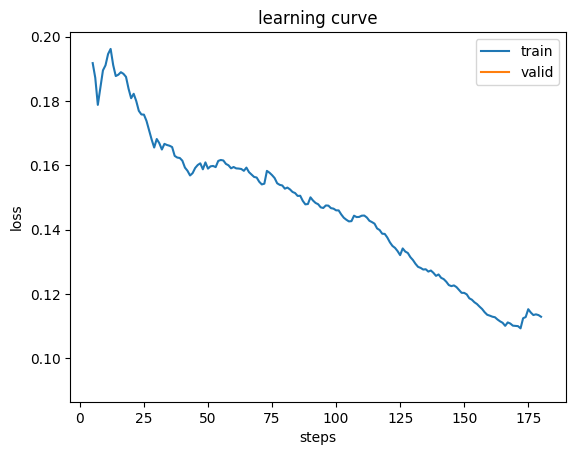

In [6]:
learn.recorder.plot_loss()

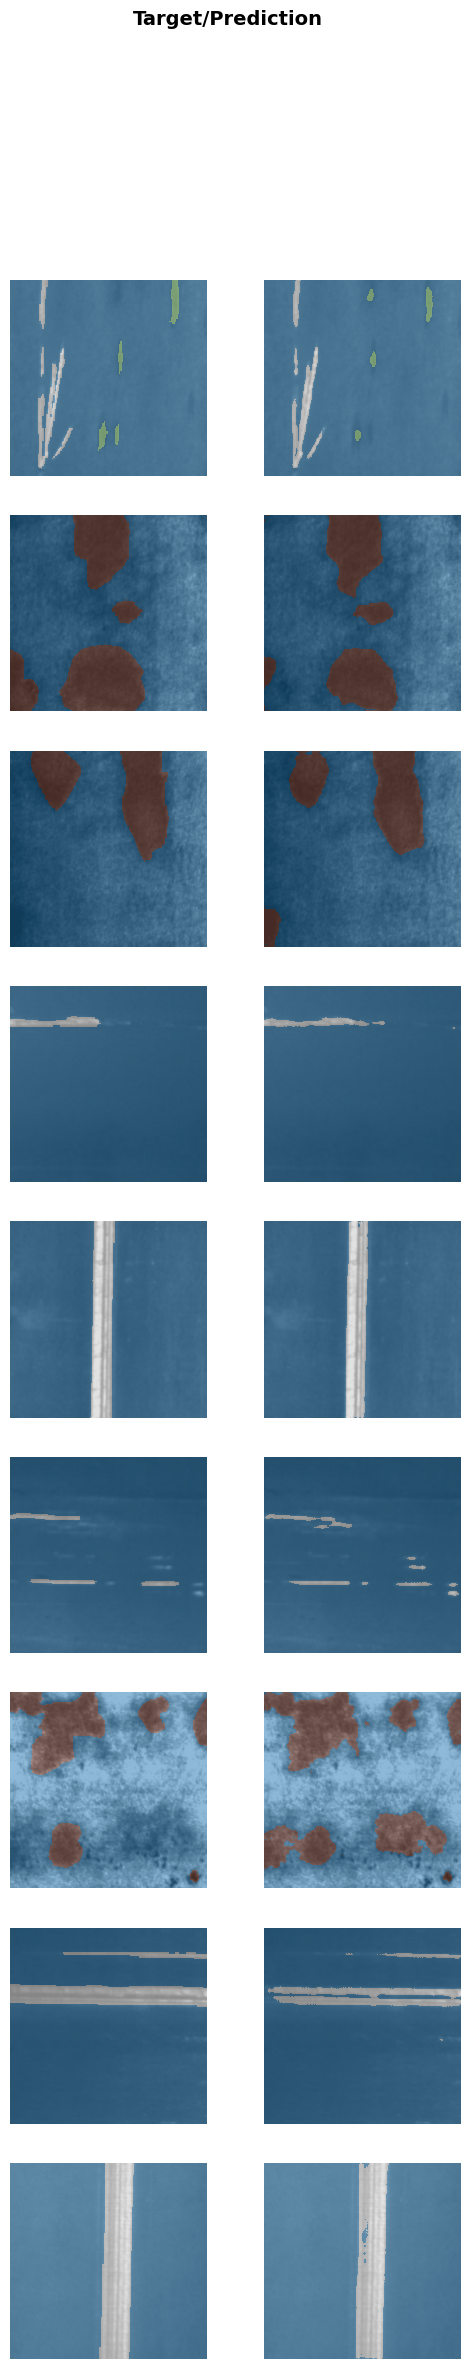

In [7]:
learn.show_results()